In [249]:
%matplotlib inline

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
import pandas as pd
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
import seaborn as sns

from matplotlib import pyplot as plt

In [251]:
# Set default cell width
display(HTML('<style>.container {width:80% !important;}</style>'))

# Set default matplotlib settings
plt.style.use('fivethirtyeight')

plt.rcParams['figure.figsize'] = (16, 7)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 24

# mpl.rcParams['lines.linewidth'] = 3
# mpl.rcParams['figure.titlesize'] = 26
# mpl.rcParams['axes.labelsize'] = 18
# mpl.rcParams['axes.titlesize'] = 22
# mpl.rcParams['xtick.labelsize'] = 14
# mpl.rcParams['ytick.labelsize'] = 14
# mpl.rcParams['legend.fontsize'] = 16

# Set seaborn colours
# blue, green, red, purple, yellow, cyan = sns.color_palette()

In [84]:
df = spark.read.option('header','true').csv('data/season_totals.csv')

In [85]:
dtype_dict = {'player' : StringType, 'pos' : StringType, 'team_id' : StringType, 'age' : IntegerType, 'g' : IntegerType, 'gs' : IntegerType, 'yr' : IntegerType}
df2 = df.fillna('0')

for c in df.schema.names[:]:
    dtype = DoubleType if c not in dtype_dict.keys() else dtype_dict[c]
    df2 = df2.withColumn(c,df2[c].cast(dtype()))

* _c0
* player
* pos
* age
* team_id
* g
* gs
* mp
* fg
* fga
* fg_pct
* fg3
* fg3a
* fg3_pct
* fg2
* fg2a
* fg2_pct
* efg_pct
* ft
* fta
* ft_pct
* orb
* drb
* trb
* ast
* stl
* blk
* tov
* pf
* pts
* yr

# View 3 pointers over time

In [155]:
# 3 pointers per minute
# cross check work
sqlContext.registerDataFrameAsTable(df2, 'df2')
df3 = sqlContext.sql('''SELECT yr,
                               sum(fg3a)/sum(mp) fg3a_pm
                        FROM df2 GROUP BY yr
                        ORDER BY yr''')

In [308]:
# 3 point attempts / minute
fga_py = df2.groupBy('yr')\
         .agg({'mp' : 'sum', 'fg3a' : 'sum', 'fga' : 'sum'})\
         .select(col('yr'), (col('sum(fga)')/col('sum(mp)')).alias('fga_pm'), (col('sum(fg3a)')/col('sum(mp)')).alias('fg3a_pm'))\
         .orderBy('yr')\
         .toPandas()

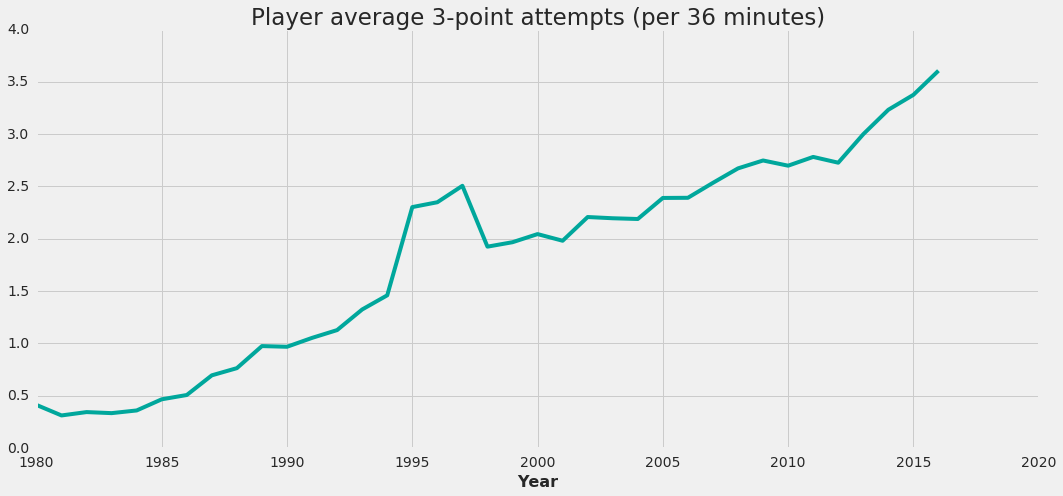

In [309]:
plt.plot(fga_py.yr,36*fga_py.fg3a_pm, color = '#00a79c')
plt.xlabel('Year')
_=plt.title('Player average 3-point attempts (per 36 minutes)')
# plt.plot(36*fga_py.fga_pm)

In [312]:
# 3 point attempts / minute
fga_py = df2.groupBy('yr')\
         .agg({'mp' : 'sum', 'fg3a' : 'sum', 'fga' : 'sum'})\
         .select(col('yr'), (col('sum(fga)')/col('sum(mp)')).alias('fga_pm'), (col('sum(fg3a)')/col('sum(mp)')).alias('fg3a_pm'))\
         .orderBy('yr')\

In [323]:
training = spark.read.format("libsvm").load("/Users/crawles/Downloads/sample_linear_regression_data.txt")
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
training.take(5)

[Row(label=-9.490009878824548, features=SparseVector(10, {0: 0.4551, 1: 0.3664, 2: -0.3826, 3: -0.4458, 4: 0.3311, 5: 0.8067, 6: -0.2624, 7: -0.4485, 8: -0.0727, 9: 0.5658})),
 Row(label=0.2577820163584905, features=SparseVector(10, {0: 0.8387, 1: -0.127, 2: 0.4998, 3: -0.2269, 4: -0.6452, 5: 0.1887, 6: -0.5805, 7: 0.6519, 8: -0.6556, 9: 0.1749})),
 Row(label=-4.438869807456516, features=SparseVector(10, {0: 0.5026, 1: 0.1421, 2: 0.16, 3: 0.505, 4: -0.9372, 5: -0.2842, 6: 0.6356, 7: -0.1646, 8: 0.9481, 9: 0.4268})),
 Row(label=-19.782762789614537, features=SparseVector(10, {0: -0.0389, 1: -0.4167, 2: 0.8997, 3: 0.641, 4: 0.2733, 5: -0.2618, 6: -0.2795, 7: -0.1307, 8: -0.0854, 9: -0.0546})),
 Row(label=-7.966593841555266, features=SparseVector(10, {0: -0.062, 1: 0.6546, 2: -0.6979, 3: 0.6677, 4: -0.0794, 5: -0.4389, 6: -0.6081, 7: -0.6415, 8: 0.7314, 9: -0.0268}))]

In [335]:
t.select('features')

DataFrame[yr: int, fga_pm: double, fg3a_pm: double, features: vector]

In [358]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

t = VectorAssembler(inputCols=['yr'], outputCol = 'features')
training = t.transform(fga_py)\
            .withColumn('yr',fga_py.yr)\
            .withColumn('label',fga_py.fg3a_pm)

lr = LinearRegression(maxIter=10)
model = lr.fit(training)


In [367]:
training.dtypes

[('yr', 'int'),
 ('fga_pm', 'double'),
 ('fg3a_pm', 'double'),
 ('features', 'vector'),
 ('label', 'double')]

[1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016]

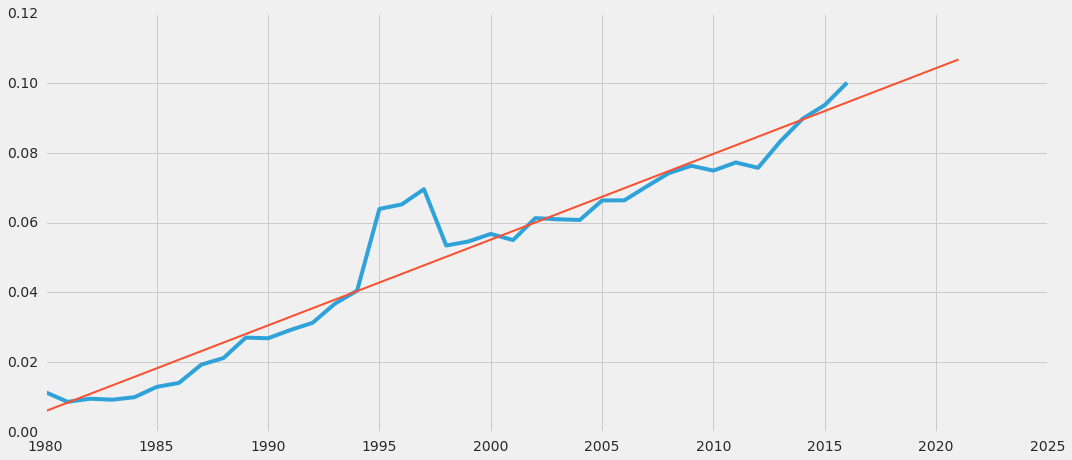

In [408]:
from pyspark.sql import Row

training_yrs = training.select('yr').rdd.map(lambda x: x[0]).collect()
training_y = training.select('fg3a_pm').rdd.map(lambda x: x[0]).collect()

testing_yrs = [2017, 2018, 2019, 2020, 2021]
all_yrs = training_yrs + testing_yrs

test_rdd = sc.parallelize(all_yrs)
row = Row('yr')
testing = t.transform(test_rdd.map(row).toDF())
df_results = model.transform(testing).toPandas()
df = df_results
plt.plot(training_yrs, training_y)
plt.plot(df.yr,df.prediction, linewidth = 2)

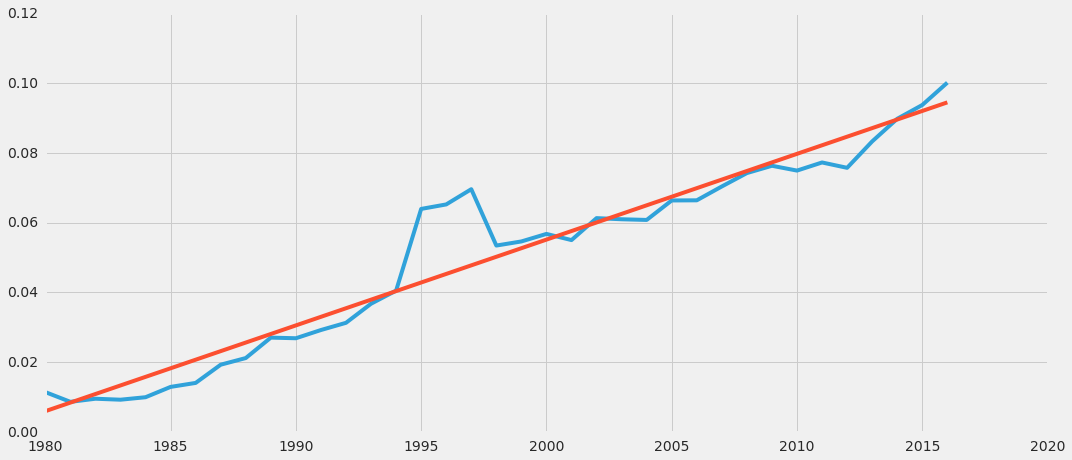

In [359]:
df = model.transform(training).toPandas()
plt.plot(df.yr,df.fg3a_pm)
plt.plot(df.yr,df.prediction, )

# Top 10 players each season

In [304]:
sqlContext.registerDataFrameAsTable(df2, 'df2')
df_top10 = sqlContext.sql('''
SELECT * 
FROM
(SELECT *,dense_rank() OVER (PARTITION BY yr order by fga DESC) AS rank
FROM df2) foo
WHERE rank <= 10
ORDER BY yr
''')
sqlContext.registerDataFrameAsTable(df_top10,'df_top10')

In [305]:
a = df_top10.filter('yr == 2016').toPandas()
import numpy as np
np.mean(a.fg3a/a.mp)*36

7.096543019268152

In [306]:
fga_py = df_top10.groupBy('yr')\
         .agg({'mp' : 'sum', 'fg3a' : 'sum', 'fga' : 'sum'})\
         .select(col('yr'), (col('sum(fga)')/col('sum(mp)')).alias('fga_pm'), (col('sum(fg3a)')/col('sum(mp)')).alias('fg3a_pm'))\
         .orderBy('yr')\
         .toPandas()
fga_py

,yr,fga_pm,fg3a_pm
0,1980,0.540218,0.013663
1,1981,0.513714,0.007069
2,1982,0.540224,0.007637
3,1983,0.535757,0.019815
4,1984,0.548977,0.014192
5,1985,0.567285,0.028526
6,1986,0.549534,0.016967
7,1987,0.569585,0.029489
8,1988,0.563800,0.036010
9,1989,0.548503,0.028824


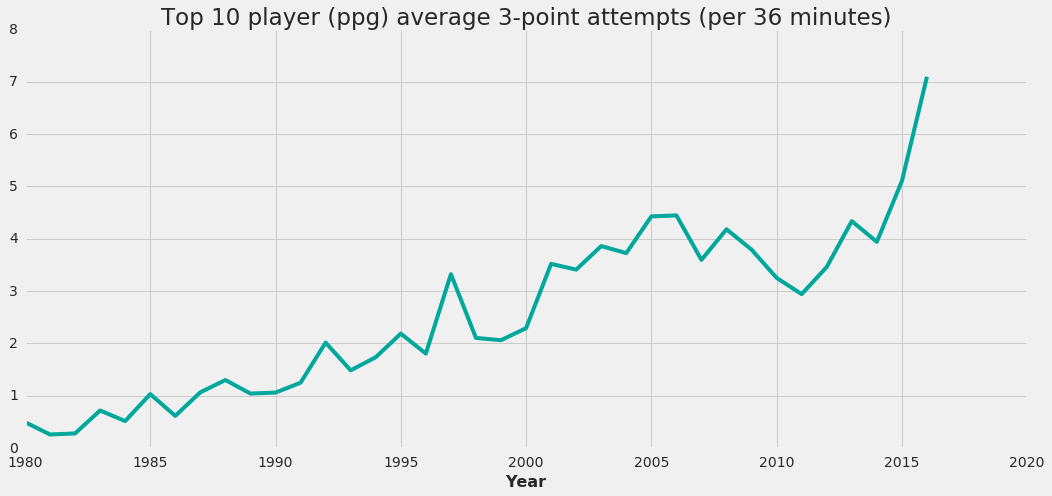

In [307]:
plt.plot(fga_py.yr,36*fga_py.fg3a_pm, color = '#00a79c')
plt.xlabel('Year')
_=plt.title('Top 10 player (fga) average 3-point attempts (per 36 minutes)')

In [301]:
df2.filter('yr >= 2011').select('fga').agg({'fga':'sum'}).take(1)

[Row(sum(fga)=1292386.0)]

# True shooting percentage

In [288]:
def calc_ts_per(row):
    pts,fga,fta = row.PTS,row.FGA,row.FTA
    return pts/(2*(fga + (0.44*fta)))

df_ts = sqlContext.sql('''
SELECT yr, SUM(pts)/(2 * (SUM(fga) + (.44 * SUM(fta)))) as ts_per
FROM df2
GROUP BY yr
ORDER BY yr
''').toPandas()

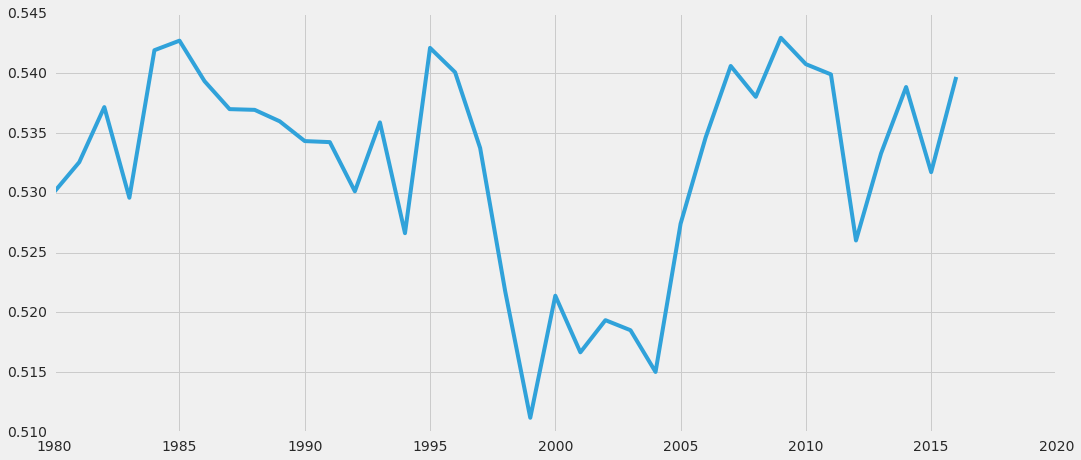

In [289]:
plt.plot(df_ts.yr, df_ts.ts_per)

In [291]:
def calc_ts_per(pts,fga,fta):
    return pts/(2*(fga + (0.44*fta)))

pstats = df2.filter('yr < 2010 and mp > 500').toPandas()
pstats['ts'] = calc_ts_per(pstats.pts,pstats.fga,pstats.fta)

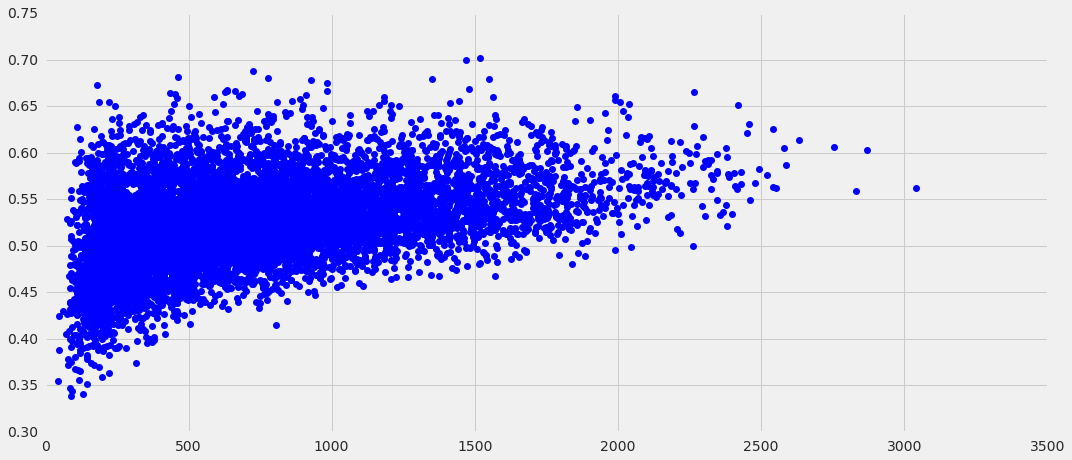

In [292]:
plt.plot(pstats.pts, pstats.ts, 'bo')

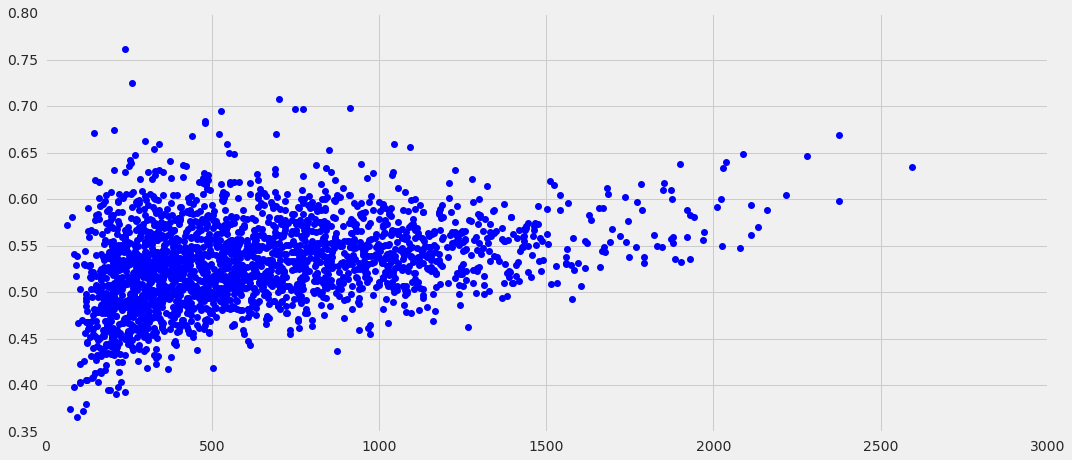

In [290]:
plt.plot(pstats.pts, pstats.ts, 'bo')

In [209]:
@register_cell_magic
def spark_sql(line, cell):
    """
    Show the SQL query that will be run.
    """
    df1,df2 = line.split(' ')
    print df1
    sqlContext.registerDataFrameAsTable(df1, '{}'.format(df1))
    print cell